# Geospatial Analysis with Choropleths

This notebook explores climate, vegetation, and fire variables' geospatial distributions. Variables include:
  1. Maximum daily temperature (°C)
  2. Maximum Windspeed (m/s)
  3. Total precipitation (mm)
  4. Normalized Difference in Vegetation Index
  5. Active fire
  6. Number of fires in prior 10 years

See prior notebooks for data cleaning and wrangling.

In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import folium
import os

In [4]:
df = pd.read_csv(r'/media/scruffy/Elements/python_data/Final/Prepared_Data/final_data.csv')

In [48]:
def plot_hexbin_maps(gdf, date_str='2017-07-07'):
    """
    Plot multiple hexbin maps with different variables on Web Mercator projection with basemap.
    
    Args:
        gdf: GeoDataFrame in EPSG:4326 (WGS84)
        date_str: Date string for plot titles
    """
    # Convert to Web Mercator (EPSG:3857) for proper basemap alignment
    gdf = gdf.to_crs(epsg=3857)
    
    # Configuration for each subplot
    plot_configs = [
    {'var': 'temperature_2m_max', 'cmap': 'YlOrRd', 'label': 'Max Temp (°C)', 'reduce': np.max},
    {'var': 'log_windspeed', 'cmap': 'Greys', 'label': 'Log of Max Windspeed (m/s)', 'reduce': np.max},
    {'var': 'total_precipitation_sum', 'cmap': 'GnBu', 'label': 'Total Precipitation (mm)', 'reduce': np.sum},
    {'var': 'NDVI', 'cmap': 'RdYlGn', 'label': 'NDVI', 'reduce': np.mean},
    {'var': 'active_fire', 'cmap': 'Reds', 'label': 'Active Fire', 'reduce': np.max},
    {'var': 'log_num_fires', 'cmap': 'inferno', 'label': 'Log of Number of Fires in Past Decade', 'reduce': np.mean}
    ]

    # Create figure and plot all variables
    fig, axes = plt.subplots(3, 2, figsize=(10, 16))
    axes = axes.flatten()
    
    for ax, config in zip(axes, plot_configs):
        # Extract coordinates from geometry
        x = gdf.geometry.x
        y = gdf.geometry.y
        
        # Create hexbin plot
        hb = ax.hexbin(
            x=x,
            y=y,
            C=gdf[config['var']],
            gridsize=60,
            cmap=config['cmap'],
            reduce_C_function=config['reduce'],
            mincnt=1,
            alpha=0.8  # Slightly transparent to see basemap
        )
        
        # Add colorbar
        plt.colorbar(hb, ax=ax, label=config['label'])
        
        # Add basemap
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
        
        # Set titles and labels
        ax.set_title(f'Hexbin Map of {config["label"].split("(")[0]} {date_str}', pad=20)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_axis_off()  # Cleaner look with basemap

    plt.tight_layout()
    plt.show()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599191 entries, 0 to 8599190
Data columns (total 27 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   date                               object 
 1   longitude                          float64
 2   latitude                           float64
 3   temperature_2m                     float64
 4   temperature_2m_max                 float64
 5   total_precipitation_sum            float64
 6   dewpoint_temperature_2m            float64
 7   volumetric_soil_water_layer_1      float64
 8   surface_net_solar_radiation_sum    float64
 9   surface_net_thermal_radiation_sum  float64
 10  surface_sensible_heat_flux_sum     float64
 11  potential_evaporation_sum          float64
 12  total_evaporation_sum              float64
 13  leaf_area_index_high_vegetation    float64
 14  leaf_area_index_low_vegetation     float64
 15  max_windspeed                      float64
 16  wind_direction    

In [6]:
# Get date as datetime
df['date'] = pd.to_datetime(df['date'])

In [ ]:
test_date = df[df['date']=='2017-08-07']

In [9]:
# Create point geometries
geometry = gpd.points_from_xy(test_date['longitude'], test_date['latitude'])

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(test_date, geometry=geometry, crs="EPSG:4326")

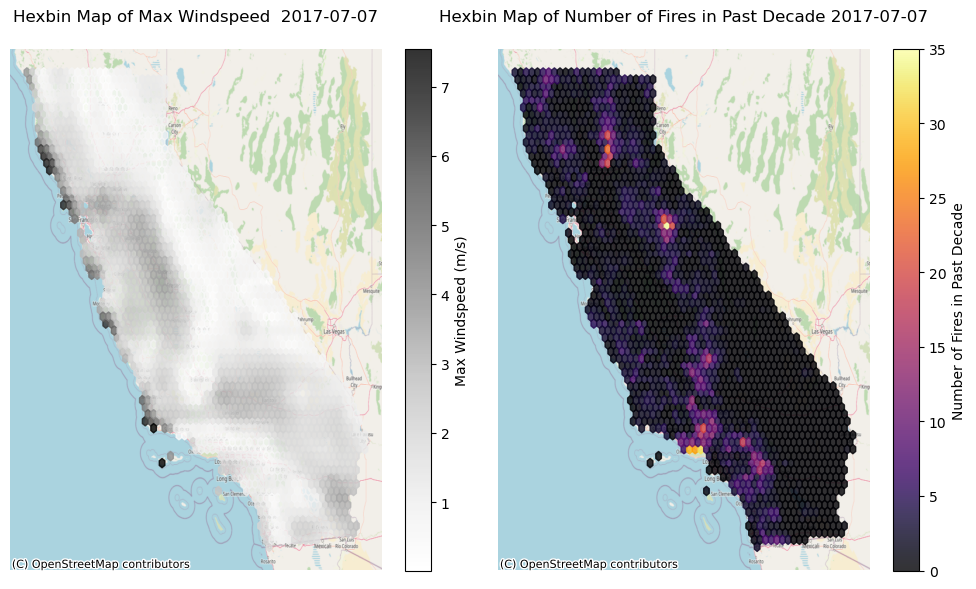

In [28]:
plot_hexbin_maps(gdf, date_str='2017-07-07')

    Visualization shows the effects of extreme right skew for these two variables which need to be normalized before further analysis.

In [12]:
gdf['log_windspeed'] = np.log1p(gdf['max_windspeed'])

In [19]:
gdf['log_num_fires'] = np.log1p(gdf['fires_past_10yrs_count'])

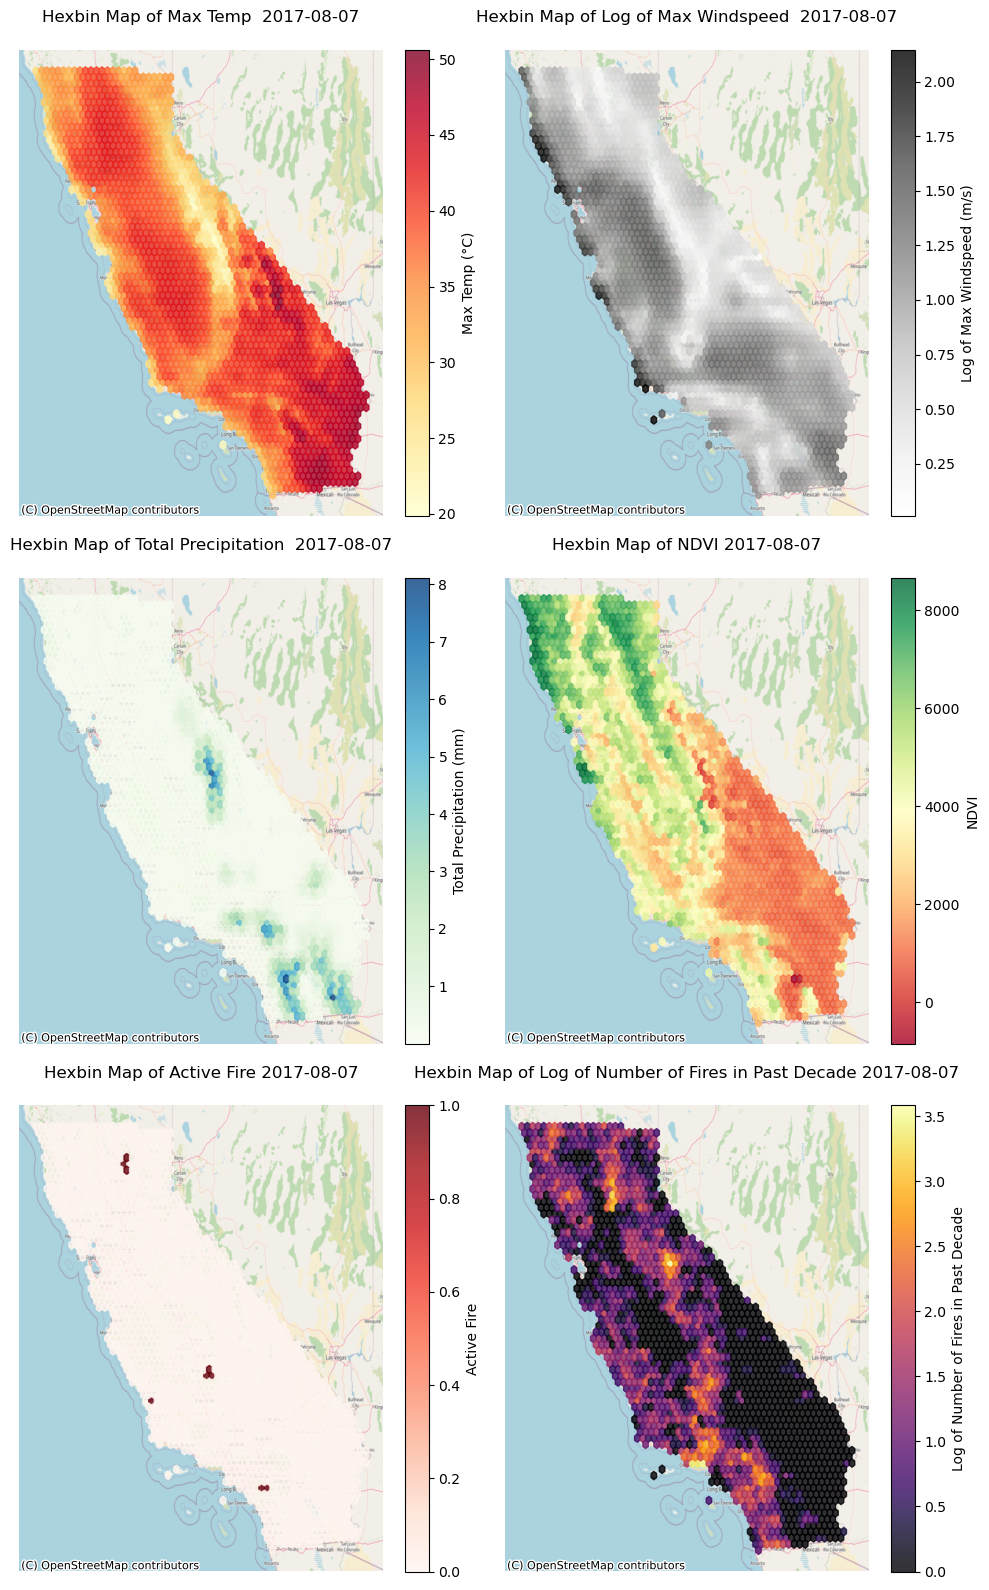

In [49]:
plot_hexbin_maps(gdf, date_str='2017-08-07')

### Discussion
    We can see certain regions where fire rarely or never occur as well as definite patterns in areas where they are very frequent.
    California has many geologically, biologically, and meteorologically distinct regions. In some of these, wildfires are much more common than others.
    There were at least four major wildfires on August 7, 2017.